In [1]:
!git clone https://github.com/NarutoUchiha39/AMLProject.git

Cloning into 'AMLProject'...
remote: Enumerating objects: 10158, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 10158 (delta 4), reused 37 (delta 2), pack-reused 10111 (from 2)
Receiving objects: 100% (10158/10158), 110.98 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Updating files: 100% (10067/10067), done.


In [1]:
cd AMLProject

/content/AMLProject


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms
from sklearn.preprocessing import OneHotEncoder
from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [3]:
data = pd.read_csv('HAM10000_metadata.csv')
path = os.path.join("DLModel","segmented_images")

dict1 = {"image_path":[]}
for i in data.columns.values:
    dict1[i] = list(data[i])

for i in dict1["image_id"]:
    dict1["image_path"].append(os.path.join("DLModel","segmented_images",i+".jpg"))

In [4]:
oneHot = OneHotEncoder()
l = []
res = oneHot.fit_transform(data["dx"].to_frame()).toarray()
for i in res:
    l.append(i.argmax())

dict1["dx_cat"] = l
data = pd.concat([pd.Series(v,name=k) for k,v in dict1.items()],axis=1)

In [5]:

data = data.sample(frac=1)
img_h, img_w = 224, 224

In [6]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [7]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [15]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [16]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 4006 Val: 4006 Test: 2003


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [13]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [16]:
start_time = time.time()

In [17]:
epochs = 30
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:08<32:59, 68.27s/it]

Epoch 1
Training Loss: 0.9690895757031819 
Training Accuracy: 67.04942586120819%
Validation Loss: 1.002457367049323 
Validation Accuracy: 67.02446330504243%
Validation Loss Decreased(inf--->1.002457) 
Saving The Model


  7%|▋         | 2/30 [02:16<31:45, 68.05s/it]

Epoch 2
Training Loss: 0.8954168674018648 
Training Accuracy: 68.62206689965052%
Validation Loss: 1.6144921869512587 
Validation Accuracy: 67.09935097353969%
Epoch 3
Training Loss: 0.8726686040560404 
Training Accuracy: 69.64553170244633%
Validation Loss: 0.9145250959055764 
Validation Accuracy: 68.2226660009985%
Validation Loss Decreased(1.002457--->0.914525) 
Saving The Model


 10%|█         | 3/30 [03:26<31:04, 69.04s/it]

Epoch 4
Training Loss: 0.851645507982799 
Training Accuracy: 70.0698951572641%
Validation Loss: 0.8989548855830752 
Validation Accuracy: 67.87319021467798%
Validation Loss Decreased(0.914525--->0.898955) 
Saving The Model


 13%|█▎        | 4/30 [04:37<30:19, 69.98s/it]

Epoch 5
Training Loss: 0.8343366592649429 
Training Accuracy: 70.16974538192711%
Validation Loss: 0.8769344122163834 
Validation Accuracy: 69.72041937094359%
Validation Loss Decreased(0.898955--->0.876934) 
Saving The Model


 20%|██        | 6/30 [06:57<27:56, 69.84s/it]

Epoch 6
Training Loss: 0.8180476275701372 
Training Accuracy: 70.34448327508737%
Validation Loss: 0.946694960196813 
Validation Accuracy: 68.84672990514228%
Epoch 7
Training Loss: 0.8294629109284234 
Training Accuracy: 70.21967049425861%
Validation Loss: 0.8379186098537748 
Validation Accuracy: 70.8936595107339%
Validation Loss Decreased(0.876934--->0.837919) 
Saving The Model


 27%|██▋       | 8/30 [09:22<26:10, 71.39s/it]

Epoch 8
Training Loss: 0.8155160870343919 
Training Accuracy: 70.66899650524213%
Validation Loss: 0.8564291965393793 
Validation Accuracy: 69.94508237643535%


 30%|███       | 9/30 [10:31<24:41, 70.56s/it]

Epoch 9
Training Loss: 0.8077791751850218 
Training Accuracy: 71.49276085871193%
Validation Loss: 0.8398662732234077 
Validation Accuracy: 70.54418372441339%


 33%|███▎      | 10/30 [11:40<23:21, 70.06s/it]

Epoch 10
Training Loss: 0.8391184965296398 
Training Accuracy: 71.44283574638042%
Validation Loss: 0.8459890307415099 
Validation Accuracy: 70.91862206689964%


 37%|███▋      | 11/30 [12:52<22:22, 70.66s/it]

Epoch 11
Training Loss: 0.811486021157295 
Training Accuracy: 71.06839740389415%
Validation Loss: 0.8410307689318581 
Validation Accuracy: 70.86869695456815%


100%|██████████| 30/30 [14:06<00:00, 28.22s/it]

Epoch 12
Training Loss: 0.7913813073010671 
Training Accuracy: 71.16824762855717%
Validation Loss: 0.8445636443202458 
Validation Accuracy: 71.19321018472291%



/content/AMLProject/functions/Model_functions.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filename)


In [18]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 14.12 minutes


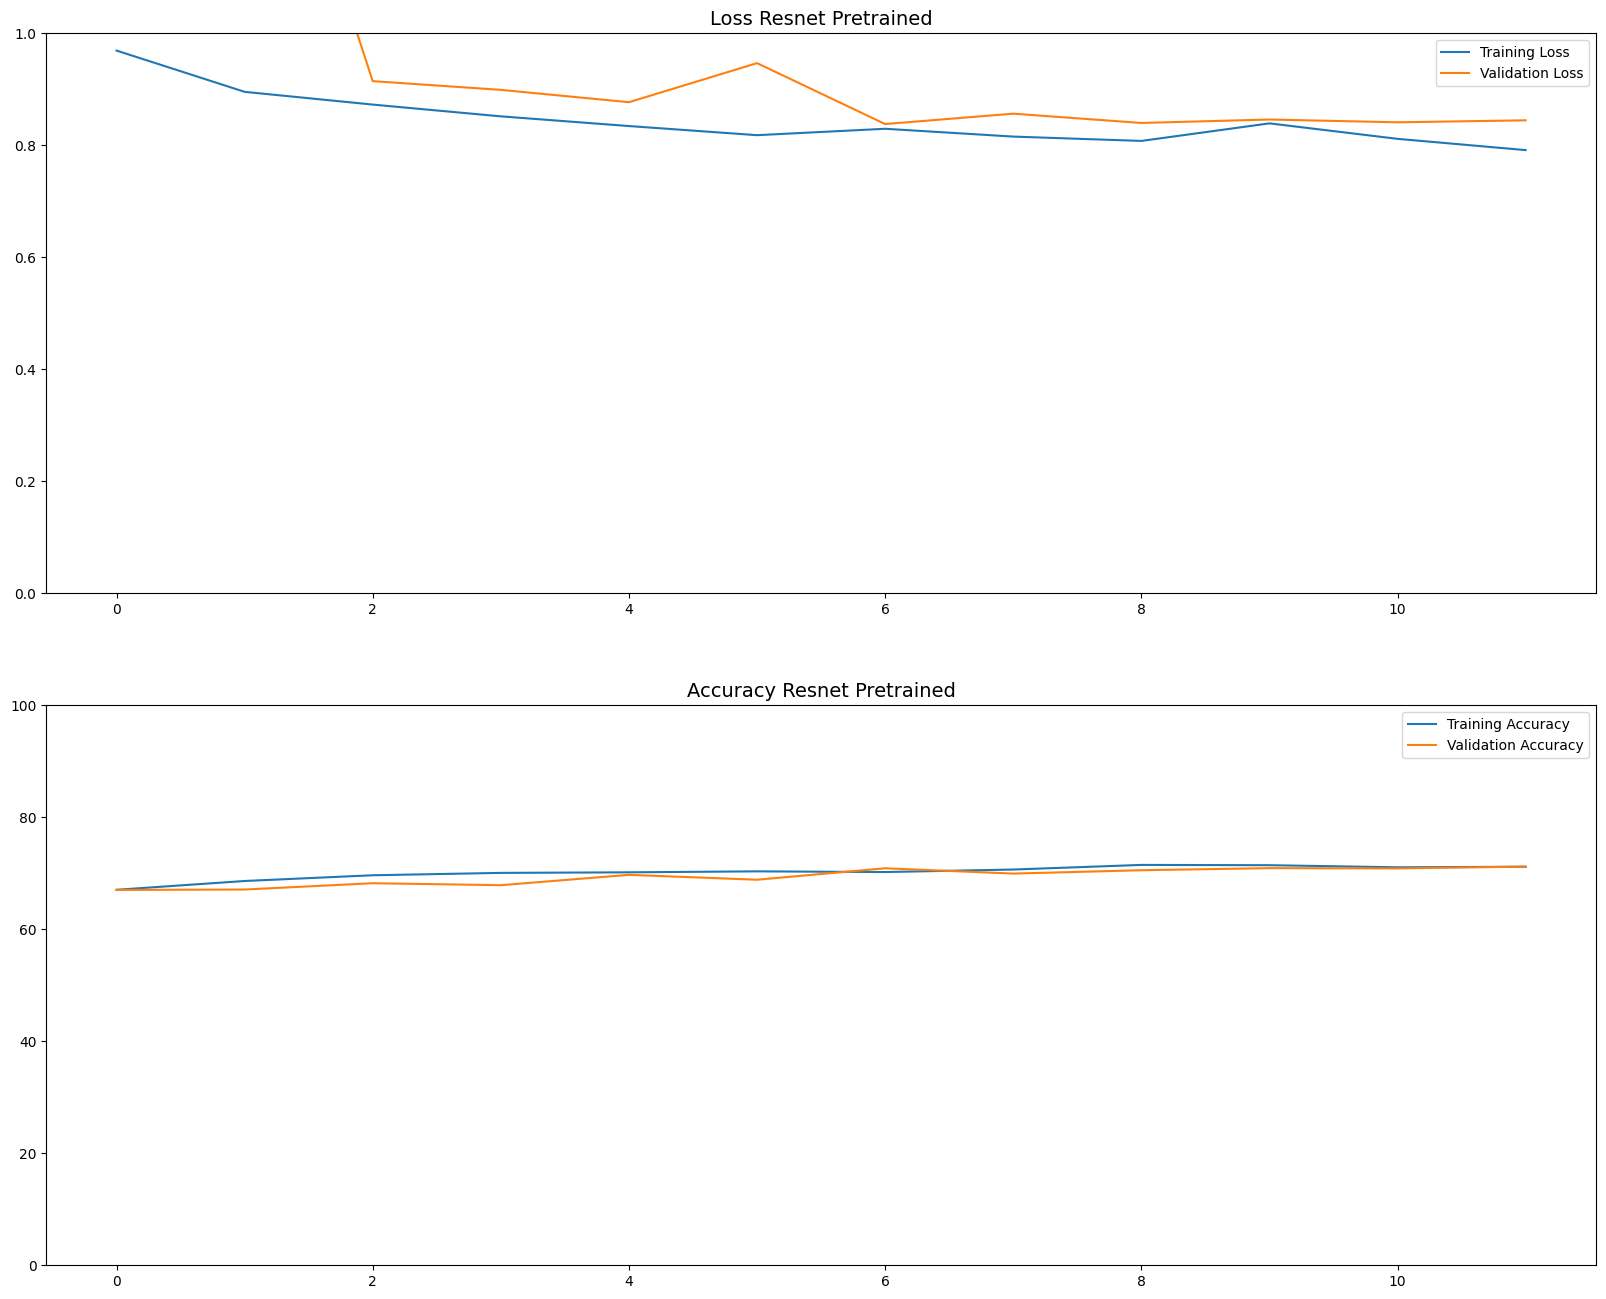

In [19]:
fig = plt.figure(num=2, figsize=(20, 16))
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)
fig2.legend()
plt.show()

In [ ]:
best_model_state = torch.load('resnet_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


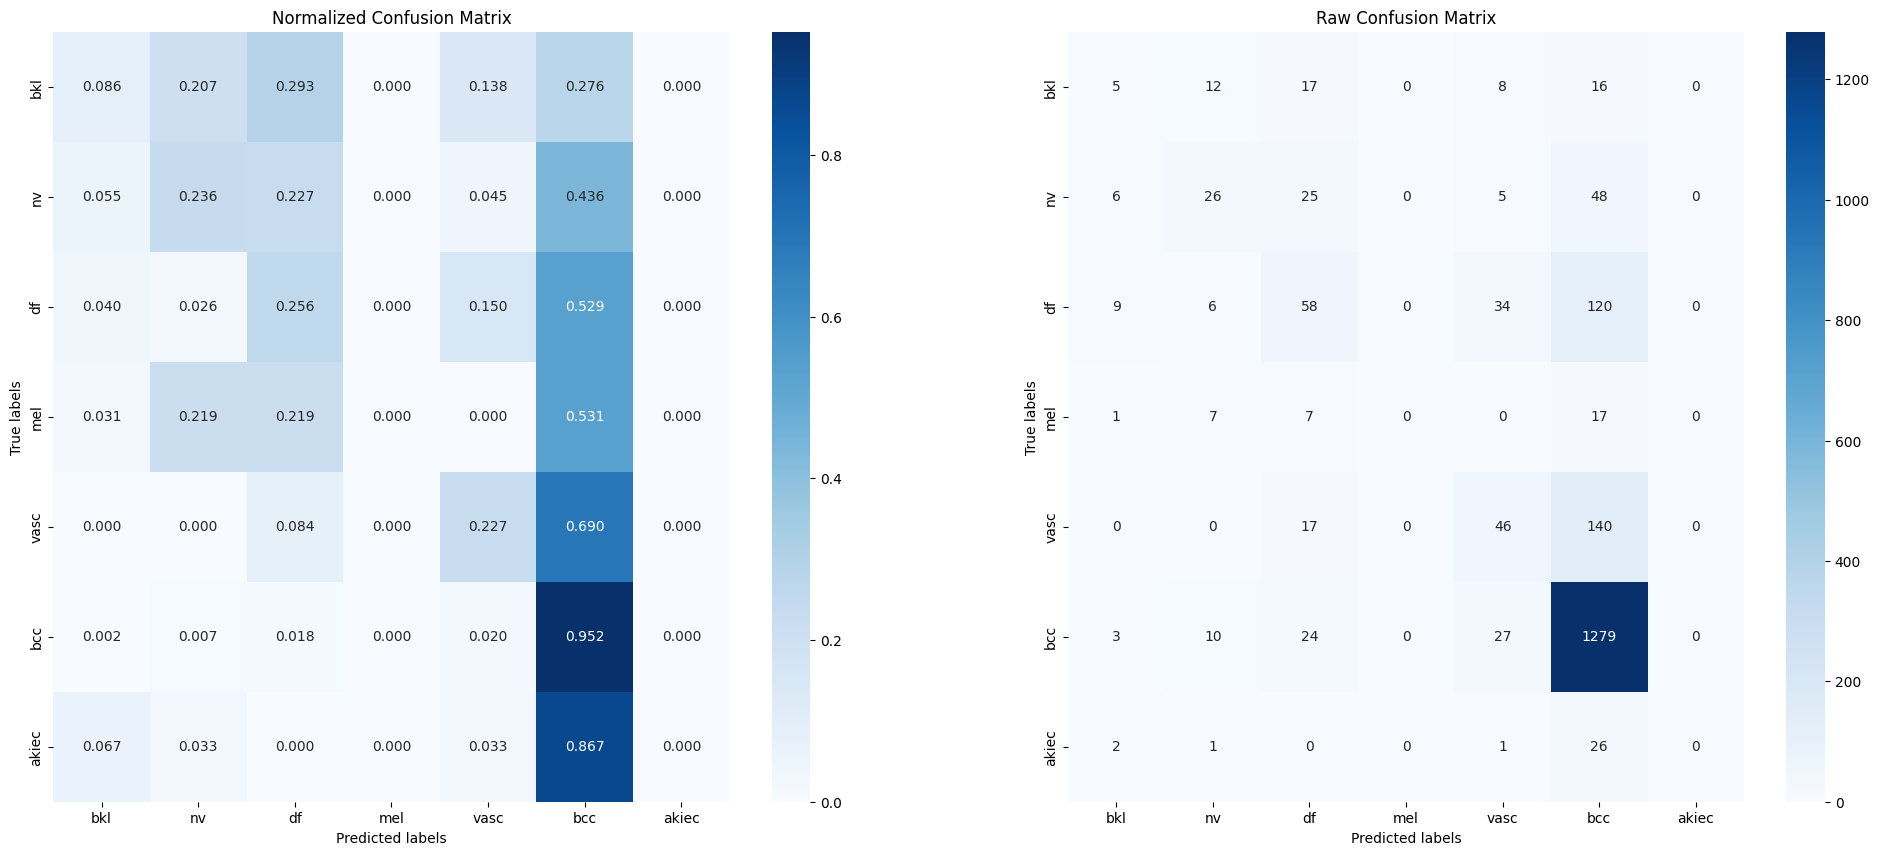

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.19      0.09      0.12        58
          nv       0.42      0.24      0.30       110
          df       0.39      0.26      0.31       227
         mel       0.00      0.00      0.00        32
        vasc       0.38      0.23      0.28       203
         bcc       0.78      0.95      0.86      1343
       akiec       0.00      0.00      0.00        30

    accuracy                           0.71      2003
   macro avg       0.31      0.25      0.27      2003
weighted avg       0.63      0.71      0.66      2003

-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
Model_functions.conf_report(model_res, test_loader, 'resnet_conf_mat')

**Empty the CUDA memory**

In [21]:
torch.cuda.empty_cache()
gc.collect()

17346

In [22]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Densenet**

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [9]:
model_temp = 'vgg19_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:08<00:00, 66.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [11]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [12]:
start_time = time.time()

In [17]:
epochs = 30
patience = 5
model_filename = 'densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Training Loss: 1.1684175015441955 
Training Accuracy: 65.92611083374938%
Validation Loss: 1.0656773684516785 
Validation Accuracy: 67.04942586120819%
Validation Loss Decreased(inf--->1.065677) 
Saving The Model


  3%|▎         | 1/30 [01:51<54:04, 111.87s/it]

Epoch 2
Training Loss: 1.0766792377782246 
Training Accuracy: 66.77483774338492%
Validation Loss: 1.0233216465465607 
Validation Accuracy: 67.04942586120819%
Validation Loss Decreased(1.065677--->1.023322) 
Saving The Model


 10%|█         | 3/30 [05:35<50:15, 111.69s/it]

Epoch 3
Training Loss: 1.0508833617445021 
Training Accuracy: 66.77483774338492%
Validation Loss: 1.1173502630184566 
Validation Accuracy: 67.04942586120819%


 13%|█▎        | 4/30 [07:24<47:54, 110.57s/it]

Epoch 4
Training Loss: 1.0441853240841912 
Training Accuracy: 66.77483774338492%
Validation Loss: 1.2702960889963877 
Validation Accuracy: 67.04942586120819%
Epoch 5
Training Loss: 1.023847713829979 
Training Accuracy: 66.77483774338492%
Validation Loss: 0.9940709604157342 
Validation Accuracy: 67.04942586120819%
Validation Loss Decreased(1.023322--->0.994071) 
Saving The Model


 20%|██        | 6/30 [11:06<44:15, 110.66s/it]

Epoch 6
Training Loss: 1.0167990215714016 
Training Accuracy: 66.69995007488767%
Validation Loss: 1.038250403271781 
Validation Accuracy: 67.04942586120819%


 23%|██▎       | 7/30 [12:56<42:19, 110.42s/it]

Epoch 7
Training Loss: 1.051866063522914 
Training Accuracy: 66.72491263105341%
Validation Loss: 1.2227383896945014 
Validation Accuracy: 67.04942586120819%
Epoch 8
Training Loss: 0.9909150657199678 
Training Accuracy: 66.3754368447329%
Validation Loss: 0.9557998279730479 
Validation Accuracy: 65.75137294058912%
Validation Loss Decreased(0.994071--->0.955800) 
Saving The Model


 27%|██▋       | 8/30 [14:49<40:45, 111.15s/it]

Epoch 9
Training Loss: 0.9388116238609193 
Training Accuracy: 66.72491263105341%
Validation Loss: 0.903307241579843 
Validation Accuracy: 68.09785322016974%
Validation Loss Decreased(0.955800--->0.903307) 
Saving The Model


 33%|███▎      | 10/30 [18:30<36:54, 110.74s/it]

Epoch 10
Training Loss: 0.9272354335065872 
Training Accuracy: 67.12431352970545%
Validation Loss: 0.9211142983228441 
Validation Accuracy: 66.94957563654518%


 37%|███▋      | 11/30 [20:21<35:02, 110.64s/it]

Epoch 11
Training Loss: 0.9375045495846915 
Training Accuracy: 66.92461308037943%
Validation Loss: 0.9165058746224358 
Validation Accuracy: 68.42236645032452%
Epoch 12
Training Loss: 0.9173870176549942 
Training Accuracy: 67.54867698452321%
Validation Loss: 0.8764519367426161 
Validation Accuracy: 68.39740389415876%
Validation Loss Decreased(0.903307--->0.876452) 
Saving The Model


 43%|████▎     | 13/30 [24:06<31:34, 111.44s/it]

Epoch 13
Training Loss: 0.9148059567761799 
Training Accuracy: 68.2226660009985%
Validation Loss: 0.88471296240413 
Validation Accuracy: 67.99800299550674%


 47%|████▋     | 14/30 [25:55<29:32, 110.79s/it]

Epoch 14
Training Loss: 0.8983014211768195 
Training Accuracy: 68.1228157763355%
Validation Loss: 0.878684258886746 
Validation Accuracy: 68.92161757363954%
Epoch 15
Training Loss: 0.8966080314583249 
Training Accuracy: 67.69845232151772%
Validation Loss: 0.8714107050309106 
Validation Accuracy: 69.39590614078881%
Validation Loss Decreased(0.876452--->0.871411) 
Saving The Model


 50%|█████     | 15/30 [27:46<27:43, 110.90s/it]

Epoch 16
Training Loss: 0.886678505511511 
Training Accuracy: 67.99800299550674%
Validation Loss: 0.8629537884678159 
Validation Accuracy: 68.69695456814777%
Validation Loss Decreased(0.871411--->0.862954) 
Saving The Model


 53%|█████▎    | 16/30 [29:37<25:52, 110.90s/it]

Epoch 17
Training Loss: 0.8702218251095878 
Training Accuracy: 69.32101847229156%
Validation Loss: 0.8522297337887779 
Validation Accuracy: 69.44583125312032%
Validation Loss Decreased(0.862954--->0.852230) 
Saving The Model


 57%|█████▋    | 17/30 [31:31<24:11, 111.65s/it]

Epoch 18
Training Loss: 0.8593614631228976 
Training Accuracy: 68.87169246130804%
Validation Loss: 0.8447706242875447 
Validation Accuracy: 70.19470793809286%
Validation Loss Decreased(0.852230--->0.844771) 
Saving The Model


 63%|██████▎   | 19/30 [35:13<20:22, 111.14s/it]

Epoch 19
Training Loss: 0.8490179661247466 
Training Accuracy: 69.59560659011483%
Validation Loss: 0.87022889109831 
Validation Accuracy: 69.49575636545183%


 67%|██████▋   | 20/30 [37:01<18:24, 110.43s/it]

Epoch 20
Training Loss: 0.8594417938637355 
Training Accuracy: 69.47079380928606%
Validation Loss: 0.8615578708667604 
Validation Accuracy: 69.19620569146281%


 70%|███████   | 21/30 [38:50<16:30, 110.03s/it]

Epoch 21
Training Loss: 0.8594315733228411 
Training Accuracy: 68.97154268597104%
Validation Loss: 0.8463794369073141 
Validation Accuracy: 68.99650524213679%


 73%|███████▎  | 22/30 [40:40<14:39, 109.90s/it]

Epoch 22
Training Loss: 0.8473508911473411 
Training Accuracy: 70.14478282576135%
Validation Loss: 1.1144715192772092 
Validation Accuracy: 54.068896655017475%


100%|██████████| 30/30 [42:31<00:00, 85.05s/it] 

Epoch 23
Training Loss: 0.8483127289348178 
Training Accuracy: 69.94508237643535%
Validation Loss: 0.8708221824869277 
Validation Accuracy: 69.82026959560659%



/content/AMLProject/functions/Model_functions.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filename)


In [18]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 43.31 minutes


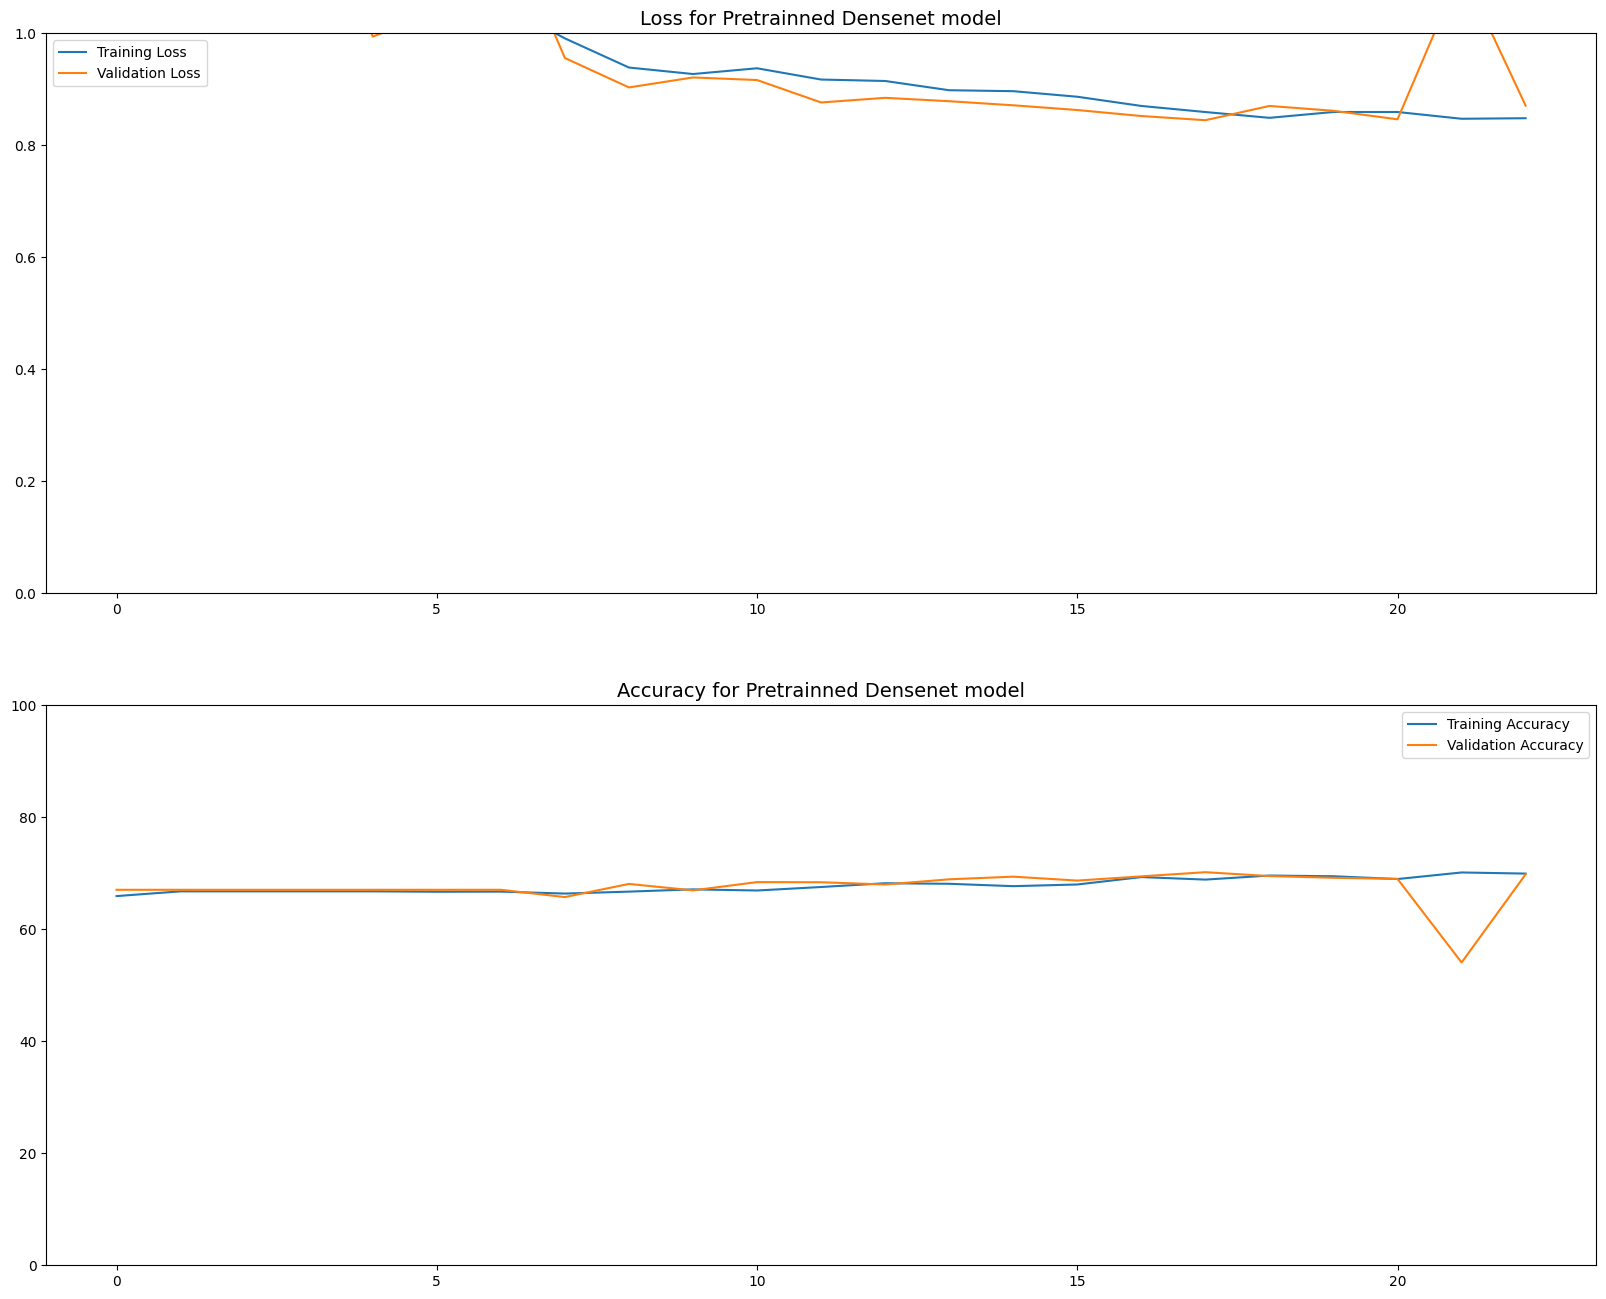

In [19]:
fig = plt.figure(num=2, figsize=(20, 16))
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)
fig2.legend()
plt.show()

In [20]:
best_model_state = torch.load('densenet_pret.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

<ipython-input-20-926e5dd1b773>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load('densenet_pret.pth',map_location='cpu')


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


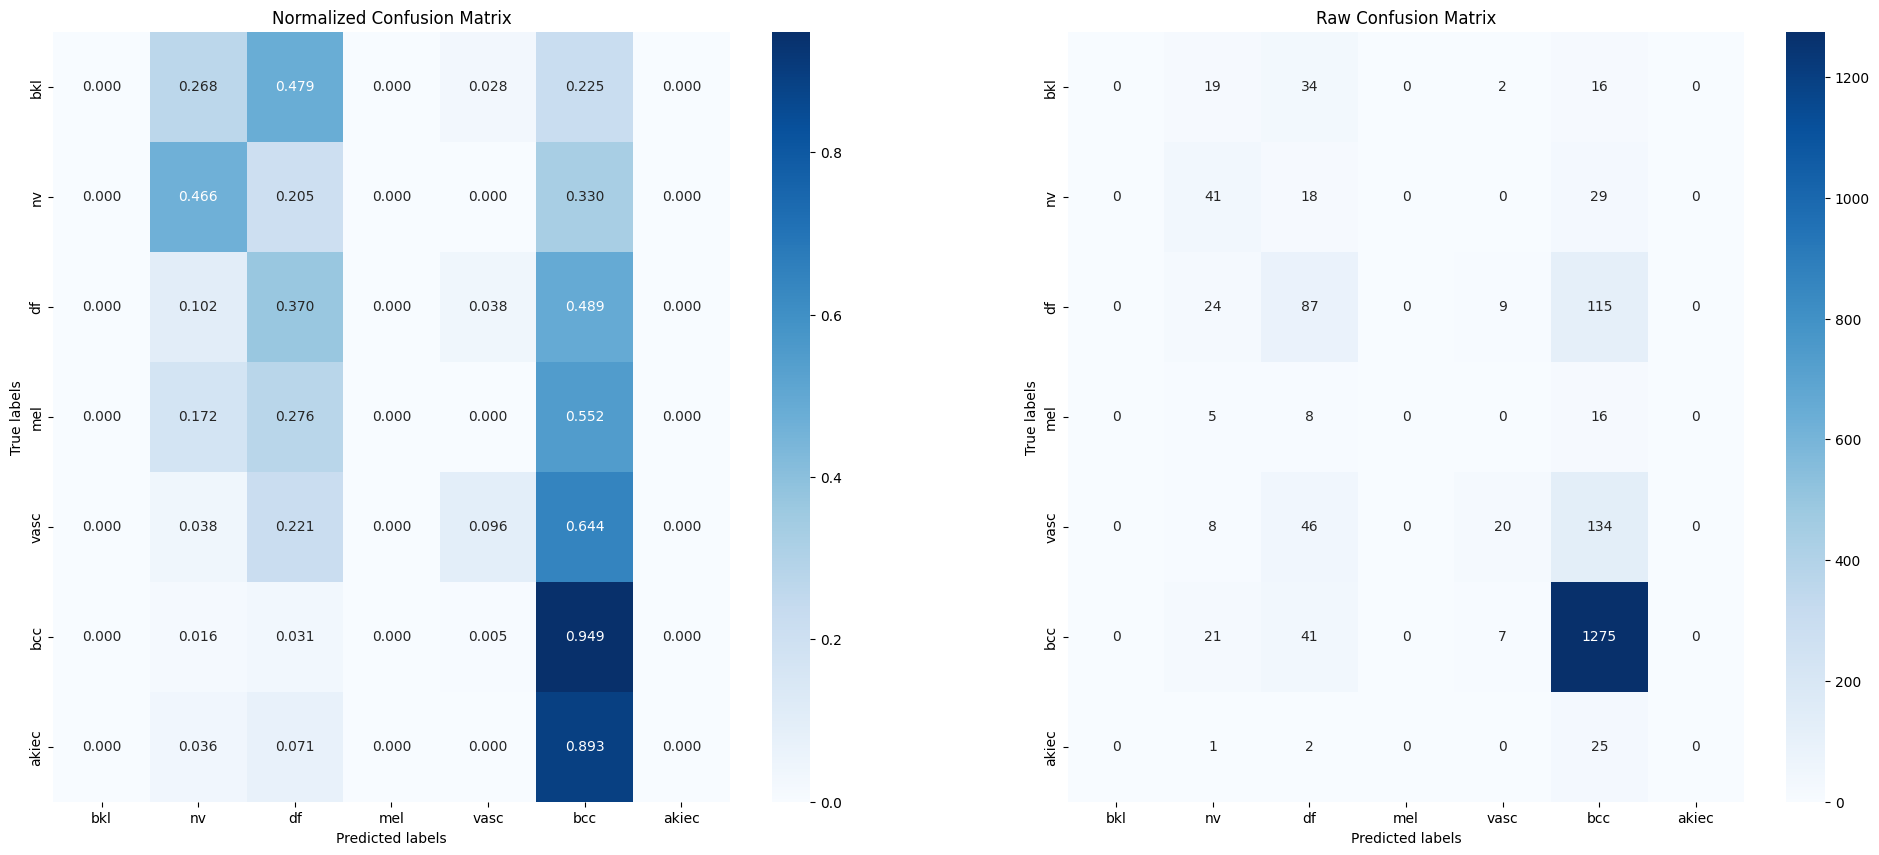

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.00      0.00      0.00        71
          nv       0.34      0.47      0.40        88
          df       0.37      0.37      0.37       235
         mel       0.00      0.00      0.00        29
        vasc       0.53      0.10      0.16       208
         bcc       0.79      0.95      0.86      1344
       akiec       0.00      0.00      0.00        28

    accuracy                           0.71      2003
   macro avg       0.29      0.27      0.26      2003
weighted avg       0.64      0.71      0.66      2003

-------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')